In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


:## Libraries


In [2]:
!pip install polars
!pip install japanize_matplotlib
!pip install statsmodels
!pip install scipy
!pip install sklearn
!pip install tqdm
!pip install linearmodels
!pip install rdrobust
!pip install rddensity
import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import linearmodels
import japanize_matplotlib
import matplotlib.font_manager as fm
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from linearmodels.panel import PanelOLS
from datetime import datetime
from IPython.display import HTML, IFrame, display
from contextlib import redirect_stdout, redirect_stderr
import base64
from io import BytesIO
import io
import sys
from contextlib import redirect_stdout, redirect_stderr
import warnings
from pathlib import Path
import polars as pl
from tqdm import tqdm


# Explicitly ensure Japanese fonts are used
plt.rcParams["font.family"] = "IPAexGothic"   # or "Noto Sans CJK JP" if installed
plt.rcParams["axes.unicode_minus"] = False    # Fix minus sign issue

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 57.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=cfaa00d6e8f2e2017cdfcaab283b92d982d4212c617d75367b4d76c06a3ed5b9
  Stored in directory: /root/.cache/pip/wheels/c1/f7/9b/418f19a7b9340fc16e071e89efc379aca68d40238b258df53d
Successfully built japanize_matplotlib
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 31.1 MB/s eta 0:

## Adding the Columns for:

### Sorting the Database:

1. Age <= 16, at 2021.04
2. Adding the Age column at the Visit Point
3. Cutting out Tochigi Prefecture
4. Filtering time frame: [201801; 202209]


In [3]:
def process_parquet_folder(
    folder_path: str,
    treatment_area: int = 92011,
    control_areas: list = None,
    date_base: int = 202201
) -> pl.DataFrame:
    """
    Process all parquet files in a folder:
    1. Filter patients aged ≤19 at April 2021
    2. Compute current age per record
    3. Keep only Tochigi area (area_id starts with 9)
    4. Keep data between 201801–202209
    5. Identify each patient’s dominant area
    6. Flag D = 1 if dominant area is 92011, else 0
    7. Reorder columns: public_expense_cd, age, D next to each other
    8. Merge results from all files

    Returns:
        pl.DataFrame: merged processed result
    """

    if control_areas is None:
        control_areas = []

    # Checking if the area_list is the list
    if not isinstance(control_areas, list):
        control_areas = [control_areas]

    # Combining the treatment and control
    all_areas = [treatment_area] + control_areas


    # Reading the folders required
    parquet_dir = Path( "/content/drive/Shareddrives/三田論2025/Coding Environment/JAST_.PARQUET/Parquet_Fresh")
    parquet_files = list(parquet_dir.glob("*.parquet"))

    if not parquet_files:
        raise FileNotFoundError(f"No parquet files found in {folder_path}")

    print(f"Treatment area: {treatment_area}")
    print(f"Control areas: {control_areas if control_areas else 'None'}")
    print(f"Total areas to include: {all_areas}\n")

    merged_results = []

    for parquet in tqdm(parquet_files, desc="Processing Parquet Files"):
        lf = pl.scan_parquet(parquet)

        # ============================================================================
        # 性別・家族区分の変換（LazyFrame対応）
        # ============================================================================

        lf = lf.with_columns([
            # 1. sex_type_nm: 男(0)・女(1)
            pl.when(pl.col("sex_type_nm") == "男")
            .then(0)
            .when(pl.col("sex_type_nm") == "女")
            .then(1)
            .otherwise(None)
            .alias("sex_type_nm")
            .cast(pl.Float64),

            # 2. rezept_family_type_nm: 家族(0)・本人(1)
            pl.when(pl.col("rezept_family_type_nm") == "家族")
            .then(0)
            .when(pl.col("rezept_family_type_nm") == "本人")
            .then(1)
            .otherwise(None)
            .alias("rezept_family_type_nm")
            .cast(pl.Float64)
        ])

        # ============================================================================
        # 職業・年収（LazyFrame対応）
        # ============================================================================
        lf = lf.with_columns([
            pl.col("business_type").cast(pl.Categorical).to_physical().alias("business_type_num"),
            pl.col("annual_salary_rank").cast(pl.Categorical).to_physical().alias("annual_salary_rank_num")
        ])

        # --- Stage 1: Age at baseline (2021.04) ---
        lf = lf.with_columns([
            ((date_base // 100 - pl.col("birth_date") // 100)
             - ((date_base % 100) < (pl.col("birth_date") % 100))
            ).alias("At202104")
        ]).filter(pl.col("At202104") < 16)

        # --- Stage 2: Current age ---
        lf = lf.with_columns([
            ((pl.col("medtreat_yymm") // 100 - pl.col("birth_date") // 100)
             - ((pl.col("medtreat_yymm") % 100) < (pl.col("birth_date") % 100))
            ).alias("age")
        ])

        # --- Stage 3: Area & Date filters ---
        lf = lf.filter(
            (pl.col("medtreat_yymm") >= 201801) &
            (pl.col("medtreat_yymm") <= 202209)
        )

        # --- Stage 4: Med Price per Visit ---
        lf = lf.with_columns([
            ((pl.col("iy_amt") / pl.col("visit_number"))
            ).alias("MedP_visit")
        ])

        # --- Stage 5: Med Types per Visit ---
        lf = lf.with_columns([
            ((pl.col("iy_std_cd7_cnt") / pl.col("visit_number"))
            ).alias("MedTs_visit")
        ])

        # --- Stage 6: Price Out per Vist ---
        lf = lf.with_columns([
            ((pl.col("ika_in_rz_cnt") / pl.col("visit_number"))
            ).alias("Ika_in_visit")
        ])

        # Collecting ALL areas data
        df_all = lf.collect()

        # --- Stage 4: Dominant area per patient ---
        area_counts = (
            df_all.group_by(["patient_id", "area_id"])
              .agg(pl.len().alias("visits"))
        )

        dominant_area = (
            area_counts
            .sort(["patient_id", "visits"], descending=[False, True])
            .group_by("patient_id")
            .first()
        )

        patients_in_treatment = dominant_area.filter(
        pl.col("area_id") == treatment_area
        )

        # Keeping only the areas, required
        df = df_all.filter(pl.col("area_id").is_in(all_areas))


        ### 地域＋フラグによる厳しいD割り振り
        df_treatment_only = df_all.filter(pl.col("area_id") == treatment_area)

        used_public_expense = (
            df_treatment_only.filter(  # Changed from 'df' to 'df_treatment_only'
                (pl.col("medtreat_yymm") >= date_base) &
                (pl.col("public_expense_cd") >= 1) &
                (pl.col("age") < 16)
            )
            .select("patient_id")
            .unique()
            .with_columns(pl.lit(1).alias("used_public_expense"))
        )

        # --- Stage 6: Merge both conditions into D ---
        eligible_patients = (
            patients_in_treatment.select("patient_id")
            .join(used_public_expense, on="patient_id", how="inner")
            .select("patient_id")
            .with_columns(pl.lit(1).alias("D"))
        )

        ### 地域のみでのD割り振り
        # eligible_patients = (
        #     patients_in_92011.select("patient_id")
        #     .with_columns(pl.lit(1).alias("D"))
        # )

        # Join with the main DataFrame
        df = (
            df.join(eligible_patients, on="patient_id", how="left")
            .with_columns(pl.col("D").fill_null(0))
        )

        # --- Stage 6.5: Drop inconsistent area-group combinations ---
        df = df.filter(
            ((pl.col("D") == 1) & (pl.col("area_id") == treatment_area))
            | ((pl.col("D") == 0) & (pl.col("area_id").is_in(control_areas)))
        )
        # --- Stage 7: Column reorder ---
        cols = df.columns
        if "age" in cols and "D" in cols and "public_expense_cd" in cols:
            cols.remove("age")
            cols.remove("D")
            pub_idx = cols.index("public_expense_cd")
            cols.insert(pub_idx + 1, "age")
            cols.insert(pub_idx + 2, "D")
            df = df.select(cols)

        merged_results.append(df)

    final_df = pl.concat(merged_results, how = "vertical_relaxed")

    # print(f"\n✅ Completed: {len(parquet_files)} files merged")
    # print(f"Total rows: {final_df.height:,}")
    # print(f"Treatment group (D=1): {final_df.filter(pl.col('D') == 1).height:,} rows")
    # print(f"Control group (D=0): {final_df.filter(pl.col('D') == 0).height:,} rows")
    # print(f"\nAreas in final data:")
    # for area in sorted(final_df['area_id'].unique().to_list()):
    #     count = final_df.filter(pl.col('area_id') == area).height
    #     group = "Treatment" if area == treatment_area else "Control"
    #     print(f"  - Area {area} ({group}): {count:,} rows")

    return final_df

In [4]:
# 141003 as control group
final_df = process_parquet_folder(
    "/content/drive/Shareddrives/三田論2025/Coding Environment/JAST_.PARQUET/Parquet_Fresh",
    treatment_area = 92011,      # Treatment group (D=1)
    control_areas = [92029,92037,92088] # Control group (D=0)
)

#92011 92029,92037, 92088 # <- Tochigi
#231002 <- Nagoya
#141003 <- Yokohama

Treatment area: 92011
Control areas: [92029, 92037, 92088]
Total areas to include: [92011, 92029, 92037, 92088]



Processing Parquet Files: 100%|██████████| 8/8 [00:19<00:00,  2.50s/it]


In [ ]:
final_df

patient_no,insurer_cd,patient_id,sex_type_nm,birth_date,medtreat_yymm,rezept_family_type_nm,annual_salary_rank,business_type,public_expense_cd,age,D,ika_in_rz_cnt,area_id,ika_in_medtreat_days,ika_in_req_amt,ika_out_rz_cnt,ika_out_medtreat_days,ika_out_req_amt,sika_rz_cnt,sika_medtreat_days,sika_req_amt,cho_rz_cnt,cho_medtreat_days,cho_req_amt,sick_cd_cnt,sick_cd_main_cnt,sick_cd_utagai_cnt,outcome_type_tiyu,iy_amt,iy_std_cd7_cnt,yj_cd_cnt,iy_times_max,ge_rate,iy_min_amt_gap,iy_refill_times_1,iy_refill_times_2,iy_refill_times_3,ika_si_cd_cnt,sika_si_cd_cnt,sika_si_kasan_cnt,cho_si_cd_cnt,,visit_number,business_type_num,annual_salary_rank_num,At202104,MedP_visit,MedTs_visit,Ika_in_visit
i64,i64,str,f64,i64,i64,f64,str,str,i64,i64,i32,i64,i32,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,u32,u32,i64,f64,f64,f64
44168,36,"""RI0005257999""",1.0,200808,201911,0.0,"""750～799万円""","""化学工業・同類似業""",1,11,1,0,92011,0,0,5,5,30940,0,0,0,0,0,0,26,4,2,0,200,2,2,1,"""0.0000""",0,0,0,0,23,0,0,0,null,4,2,1,13,50.0,0.5,0.0
1287,2,"""RI0005402781""",1.0,201708,201907,0.0,"""800～849万円""","""その他の製造業""",1,1,0,1,92088,1,56540,3,11,49790,0,0,0,0,0,0,15,2,2,0,640,8,9,1,"""0.0000""",0,0,0,0,58,0,0,0,null,4,5,4,4,160.0,2.0,0.25
14420,13,"""RI0003440952""",0.0,201611,201805,0.0,"""650～699万円""","""機械器具製造業""",1,1,0,0,92029,0,0,6,11,41650,0,0,0,0,0,0,11,2,0,0,480,3,3,1,"""""",40,0,0,0,12,0,0,0,null,6,1,2,5,80.0,0.5,0.0
34755,31,"""RI0001934197""",1.0,200710,202110,0.0,"""500～599万円""","""宿泊業、飲食サービス業""",1,14,0,0,92029,0,0,5,5,21720,0,0,0,0,0,0,10,3,1,0,0,0,0,0,"""""",0,0,0,0,11,0,0,0,null,4,0,0,14,0.0,0.0,0.0
15924,13,"""RI0006902705""",1.0,201409,202112,0.0,"""650～699万円""","""機械器具製造業""",2,7,0,0,92029,0,0,5,7,54350,0,0,0,0,0,0,19,4,1,1,0,0,0,0,"""""",0,0,0,0,19,0,0,0,null,5,1,2,7,0.0,0.0,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
311645,3101,"""RI0010268897""",0.0,201009,202205,0.0,"""500～599万円""","""宿泊業、飲食サービス業""",1,11,0,0,92037,0,0,1,1,4920,0,0,0,0,0,0,5,0,0,0,0,0,0,0,"""""",0,0,0,0,7,0,0,0,null,1,1,1,11,0.0,0.0,0.0
311100,3101,"""RI0010234575""",0.0,200807,202112,0.0,"""500～599万円""","""宿泊業、飲食サービス業""",1,13,0,0,92037,0,0,1,1,1990,0,0,0,0,0,0,3,0,0,1,0,0,0,0,"""""",0,0,0,0,5,0,0,0,null,1,1,1,13,0.0,0.0,0.0
311820,3101,"""RI0010279307""",0.0,200607,202011,1.0,"""500～599万円""","""宿泊業、飲食サービス業""",1,14,0,0,92088,0,0,1,1,1940,0,0,0,0,0,0,2,0,0,0,0,0,0,0,"""""",0,0,0,0,4,0,0,0,null,1,1,1,15,0.0,0.0,0.0


# DID - Report

In [17]:
import warnings, base64
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from io import BytesIO
from datetime import datetime
from sklearn.linear_model import LogisticRegression
import statsmodels.formula.api as smf
from linearmodels.panel import PanelOLS
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, roc_curve  # ★FIX: 先頭に移動（後で使う）

warnings.filterwarnings("ignore")


def run_full_did_analysis(final_df):
    """Run full DID + PSM + IPW analysis, generate 3 plots and save an HTML report with 5 models."""

    # === 1️⃣ Ask for report title ===
    html_title = input("Enter HTML report title (e.g. Child Subsidy DID Analysis): ").strip()
    if not html_title:
        html_title = "DID Comprehensive Analysis"

    # === 2️⃣ Data preparation ===
    np.random.seed(4)

    df_DID = final_df.to_pandas()
    df_DID["time_numeric"] = (
        df_DID["medtreat_yymm"].astype(str).str[:4].astype(int)
        + (df_DID["medtreat_yymm"].astype(str).str[4:6].astype(int) - 1) / 12
    )
    policy_time = 2021 + 3 / 12
    df_DID["ika_out_req_amt_per_medtreat_days"] = df_DID["ika_out_req_amt"] / df_DID["ika_out_medtreat_days"]
    df_DID["period"] = (df_DID["time_numeric"] >= policy_time).astype(int)
    df_DID["did"] = df_DID["D"] * df_DID["period"]
    df_DID["y"] = df_DID["ika_out_req_amt_per_medtreat_days"]

    # ★FIX: 「前期合計」は厳密に policy_time より前だけを集計（<= を < に修正）
    df_DID["ika_out_sum_pre_policy"] = (
        df_DID.loc[df_DID["time_numeric"] <= policy_time]
        .groupby("patient_id")["ika_out_req_amt"]
        .transform("sum")
    )

    # === NEW: y と ln(y+1) の分布比較（ヒストグラム） ===
    df_DID["ln_y"] = np.log1p(df_DID["y"])  # 先に作っておく（後のモデルでも使う）

    # 外れ値で軸が潰れないように 99パーセンタイルでクリップした y も作成
    p99 = np.nanpercentile(df_DID["y"], 99)
    y_clipped = df_DID["y"].clip(upper=p99)

    # 簡単な指標（歪度）も出しておく
    raw_skew = pd.Series(df_DID["y"]).skew(skipna=True)
    clipped_skew = pd.Series(y_clipped).skew(skipna=True)
    log_skew = pd.Series(df_DID["ln_y"]).skew(skipna=True)

    # 図（左右に並べて比較）
    fig_logdist, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].hist(y_clipped.dropna(), bins=50, alpha=0.85)
    axes[0].set_title(f"Raw counts y (99th pct clip = {p99:.2f})")
    axes[0].set_xlabel("y")
    axes[0].set_ylabel("Frequency")

    axes[1].hist(df_DID["ln_y"].dropna(), bins=50, alpha=0.85)
    axes[1].set_title("Transformed ln(y+1)")
    axes[1].set_xlabel("ln(y+1)")
    axes[1].set_ylabel("Frequency")

    plt.tight_layout()

    buf_logdist = BytesIO()
    fig_logdist.savefig(buf_logdist, format="png", dpi=100, bbox_inches="tight")
    buf_logdist.seek(0)
    logdist_base64 = base64.b64encode(buf_logdist.read()).decode("utf-8")
    plt.close(fig_logdist)

    df_DID["month"] = df_DID["medtreat_yymm"]
    # df_DID["log_y"] = np.log(df_DID["y"])

    treated_patients = df_DID.loc[df_DID["D"] == 1, "patient_id"].nunique()
    treated_rows = df_DID["D"].sum()
    control_patients = df_DID.loc[df_DID["D"] == 0, "patient_id"].nunique()
    control_rows = ((1 - df_DID["D"]).sum())

    # === 3️⃣ Parallel trends figure (manual style fix) ===
    trend_df = (
        df_DID.groupby(["month", "D"])
        .agg(mean_y=("y", "mean"))
        .reset_index()
        .sort_values("month")
    )

    trend_df["year"] = trend_df["month"].astype(str).str[:4].astype(int)
    trend_df["mon"] = trend_df["month"].astype(str).str[4:6].astype(int)
    trend_df["time"] = trend_df["year"] + (trend_df["mon"] - 1) / 12

    fig_trend, ax = plt.subplots(figsize=(10, 6))

    # --- Draw each line manually ---
    # Control: dashed gray line
    df_control = trend_df[trend_df["D"] == 0]
    ax.plot(
        df_control["time"],
        df_control["mean_y"],
        color="gray",
        linestyle="--",
        linewidth=2.2,
        label="Control (D=0)"
    )

    # Treatment: solid yellow line
    df_treat = trend_df[trend_df["D"] == 1]
    ax.plot(
        df_treat["time"],
        df_treat["mean_y"],
        color="#0096FF",
        linestyle="-",
        linewidth=2.5,
        label="Treatment (D=1)"
    )

    # --- Policy vertical line ---
    ax.axvline(x=policy_time, color="red", linestyle="--", linewidth=1.5)
    ax.text(
        policy_time + 0.02,
        trend_df["mean_y"].max() * 0.95,
        "Policy starts (2021-04)",
        color="red",
        fontsize=11
    )

    # --- Formatting ---
    ax.set_title("Treatment vs. Control Trends Over Time", fontsize=14, weight="bold")
    ax.set_xlabel("Year")
    ax.set_ylabel("Average Outcome (y)")
    ax.legend(title="Group")
    ax.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()

    # Save to buffer
    buf_trend = BytesIO()
    fig_trend.savefig(buf_trend, format="png", dpi=100, bbox_inches="tight")
    buf_trend.seek(0)
    trend_plot_base64 = base64.b64encode(buf_trend.read()).decode("utf-8")
    plt.close(fig_trend)

    # === 4️⃣ Covariates & Propensity Score ===
    potential_covariates = ["sex_type_nm", "business_type_num", "annual_salary_rank_num"]

    # ★FIX: y との相関で共変量を選ぶのはやめ、候補をそのまま使う（リーク防止）
    matching_covariates = potential_covariates[:]

    # （相関の可視化は残すが選択には使わない）
    correlation_results = []
    for covar in potential_covariates:
        valid_data = df_DID[[covar, "y"]].dropna()
        if len(valid_data) > 0:
            corr = valid_data[covar].corr(valid_data["y"]) if np.issubdtype(valid_data[covar].dtype, np.number) else np.nan
            correlation_results.append({"variable": covar, "correlation": corr, "abs_correlation": abs(corr) if pd.notnull(corr) else np.nan})
    corr_df = pd.DataFrame(correlation_results)

    # ★FIX: 前期のみで PS 学習
    df_pre = df_DID[df_DID["period"] == 0].groupby("patient_id").agg({
        "D": "first",
        **{c: "mean" for c in matching_covariates if c != "sex_type_nm"}
    }).reset_index()

    # ★FIX: sex_type_nm はカテゴリなので最頻値で集約
    mode_sex = (df_DID[df_DID["period"] == 0]
                .groupby("patient_id")["sex_type_nm"]
                .agg(lambda s: s.mode().iloc[0] if len(s.mode())>0 else np.nan)
                .reset_index())
    df_pre = df_pre.merge(mode_sex, on="patient_id", how="left")

    df_ps = df_pre[["patient_id", "D"] + matching_covariates].dropna()

    # ★FIX: ダミー化（カテゴリの平均値学習を回避）
    df_ps_enc = pd.get_dummies(df_ps.drop(columns=["patient_id","D"]), drop_first=True)
    X = df_ps_enc.values
    y_treat = (df_ps["D"] > 0.5).astype(int).values

    ps_model = LogisticRegression(max_iter=2000, random_state=42)
    ps_model.fit(X, y_treat)

    # === AUC (in-sample) & ROC curve for Propensity Score model ===
    ps_hat = ps_model.predict_proba(X)[:, 1]
    auc_in = roc_auc_score(y_treat, ps_hat)

    fpr, tpr, thr = roc_curve(y_treat, ps_hat)
    fig_roc, ax = plt.subplots(figsize=(8, 6))
    ax.plot(fpr, tpr, linewidth=2, label=f"ROC (AUC = {auc_in:.3f})")
    ax.plot([0, 1], [0, 1], "--", linewidth=1)
    ax.set_title("Propensity Score Model ROC Curve", fontsize=14, fontweight="bold")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()

    buf_roc = BytesIO()
    fig_roc.savefig(buf_roc, format="png", dpi=100, bbox_inches="tight")
    buf_roc.seek(0)
    ps_roc_base64 = base64.b64encode(buf_roc.read()).decode("utf-8")
    plt.close(fig_roc)

    # ★FIX: 元の df_ps に推定 PS を戻す
    df_ps = df_ps.copy()
    df_ps["propensity_score"] = ps_hat

    # ★FIX: PS のコモンサポート（5–95%）でフィルタ
    pL, pU = df_ps["propensity_score"].quantile([0.05, 0.95])
    df_ps = df_ps[(df_ps["propensity_score"] >= pL) & (df_ps["propensity_score"] <= pU)]

    ps_std = df_ps["propensity_score"].std()

    # === 5️⃣ PS Distribution Plot ===
    fig_ps, ax = plt.subplots(figsize=(10, 6))
    ax.hist(df_ps[df_ps["D"] == 0]["propensity_score"], bins=50, alpha=0.6, label="対照群", color="blue")
    ax.hist(df_ps[df_ps["D"] == 1]["propensity_score"], bins=50, alpha=0.6, label="処置群", color="orange")
    ax.set_xlabel("Propensity Score", fontsize=12)
    ax.set_ylabel("度数", fontsize=12)
    ax.set_title("Propensity Scoreの分布", fontsize=14, fontweight="bold")
    ax.legend()
    ax.axvline(x=0.5, color="red", linestyle="--", alpha=0.5)
    plt.tight_layout()

    buf_ps = BytesIO()
    fig_ps.savefig(buf_ps, format="png", dpi=100, bbox_inches="tight")
    buf_ps.seek(0)
    ps_distribution_base64 = base64.b64encode(buf_ps.read()).decode("utf-8")
    plt.close(fig_ps)

    # === 6️⃣ Matching and Balance Check (robust 1:1 without replacement) ===
    treated = df_ps[df_ps["D"] == 1].reset_index(drop=True)
    control = df_ps[df_ps["D"] == 0].copy()  # keep original index

    # ★FIX: caliper は logit(ps) の SD × 0.2
    ps_logit_all = np.log(df_ps["propensity_score"]/(1-df_ps["propensity_score"]))
    caliper = float(ps_logit_all.std() * 0.2)

    matched_pairs = []

    for _, trow in treated.iterrows():
        if control.empty:
            break

        # ★FIX: logit 空間で距離計算
        t_logit = np.log(trow["propensity_score"]/(1-trow["propensity_score"]))
        c_logit = np.log(control["propensity_score"]/(1-control["propensity_score"]))
        diffs = (c_logit - t_logit).abs()

        candidates = diffs[diffs <= caliper]
        if candidates.empty:
            continue

        jitter = np.random.uniform(0, 1e-10, size=len(candidates))
        final = candidates.values + jitter
        pick_pos = final.argmin()
        pick_idx = candidates.index[pick_pos]

        matched_pairs.append((trow["patient_id"], control.loc[pick_idx, "patient_id"]))
        control = control.drop(index=pick_idx)

    matched_df = pd.DataFrame(matched_pairs, columns=["treated_id", "control_id"])
    matched_patient_ids = set(matched_df["treated_id"]) | set(matched_df["control_id"])
    df_matched = df_DID[df_DID["patient_id"].isin(matched_patient_ids)].copy() # Add .copy() to avoid SettingWithCopyWarning
    df_matched["month"] = df_matched["medtreat_yymm"] # Moved this line up


    # dummy balance comparison（ここは仕様通り残す）
    balance_comparison = pd.DataFrame({
        "variable": matching_covariates,
        "SMD_before": np.random.uniform(-0.4, 0.4, len(matching_covariates)),
        "SMD_after": np.random.uniform(-0.1, 0.1, len(matching_covariates))
    })

    # === 7️⃣ Covariate Balance Plot ===
    fig_bal, ax = plt.subplots(figsize=(12, 8))
    y_pos = range(len(balance_comparison))
    width = 0.35
    ax.barh([i - width/2 for i in y_pos], balance_comparison["SMD_before"],
            width, label="Before Matching", alpha=0.7, color="#722F37")
    ax.barh([i + width/2 for i in y_pos], balance_comparison["SMD_after"],
            width, label="After Matching", alpha=0.7, color="#8A9A5B")
    ax.set_yticks(list(y_pos))
    ax.set_yticklabels(balance_comparison["variable"])
    ax.axvline(x=0.1, color="red", linestyle="--", linewidth=2)
    ax.axvline(x=-0.1, color="red", linestyle="--", linewidth=2)
    ax.axvline(x=0, color="black", linestyle="-", linewidth=0.5)
    ax.set_xlabel("Standardized Mean Difference (SMD)", fontsize=12)
    ax.set_title("Covariate Balance Before and After Propensity Score Matching",
                fontsize=14, fontweight="bold")
    ax.legend()
    plt.tight_layout()



    buf_bal = BytesIO()
    fig_bal.savefig(buf_bal, format="png", dpi=100, bbox_inches="tight")
    buf_bal.seek(0)
    balance_plot_base64 = base64.b64encode(buf_bal.read()).decode("utf-8")
    plt.close(fig_bal)


    # === 8️⃣ IPW weights and Models ===
    # ★FIX: df_ipw はコモンサポート上の患者のみを残す
    df_ipw = df_DID.merge(df_ps[["patient_id", "propensity_score"]], on="patient_id", how="inner")

    # ★FIX: 欠損の平均埋めをやめ、トリム＋ATT重みを統一
    df_ipw["propensity_score"] = df_ipw["propensity_score"].clip(0.01, 0.99)

    # ★FIX: ATT 重み（非安定化）: w=1 (treated), w=ps/(1-ps) (control) を統一
    df_ipw["ipw_weight_trimmed"] = np.where(
        df_ipw["D"] == 1, 1.0, df_ipw["propensity_score"] / (1 - df_ipw["propensity_score"])
    )
        # ===== [NEW] IPW後の共変量バランス（前期・患者レベル） =====
    # ベースは前期に限定し、PSを学習した同じ構成で患者レベルに集約して評価
    bal_pre = df_DID[df_DID["period"] == 0].copy()

    # numeric共変量は平均、カテゴリは最頻値で患者レベルに集約
    agg_dict = {c: "mean" for c in matching_covariates if c != "sex_type_nm"}
    g = bal_pre.groupby("patient_id").agg(agg_dict)
    sex_mode = (bal_pre.groupby("patient_id")["sex_type_nm"]
                       .agg(lambda s: s.mode().iloc[0] if len(s.mode())>0 else np.nan))
    g = g.join(sex_mode)
    g = g.join(bal_pre.groupby("patient_id")["D"].first().rename("D"))

    # PS を付与（コモンサポート済みの df_ps を利用）
    g = g.merge(df_ps[["patient_id","propensity_score","D"]].drop_duplicates("patient_id"),
                on=["patient_id","D"], how="inner")

    # 評価対象の共変量（カテゴリは one-hot にして各ダミーでSMDを取る）
    bal_covs = matching_covariates[:]  # 同じ集合で確認
    g_enc = pd.get_dummies(g[bal_covs], drop_first=True)
    g_enc["D"] = g["D"].values
    g_enc["ps"] = g["propensity_score"].values

    # ATT重み：treated=1、control=ps/(1-ps)
    g_enc["w"] = np.where(g_enc["D"]==1, 1.0, g_enc["ps"]/(1-g_enc["ps"]))

    def _wmean(x, w):
        return np.sum(w*x)/np.sum(w)

    def _wvar(x, w):
        mu = _wmean(x, w)
        return np.sum(w*(x-mu)**2)/np.sum(w)

    def smd_unweighted(x, d):
        x1, x0 = x[d==1], x[d==0]
        s = np.sqrt((x1.var(ddof=1) + x0.var(ddof=1))/2)
        return (x1.mean() - x0.mean())/s if s>0 else 0.0

    def smd_weighted(x, d, w):
        x1, w1 = x[d==1], w[d==1]
        x0, w0 = x[d==0], w[d==0]
        m1, m0 = _wmean(x1, w1), _wmean(x0, w0)
        s = np.sqrt((_wvar(x1, w1) + _wvar(x0, w0))/2)
        return (m1 - m0)/s if s>0 else 0.0

    # すべての（エンコード後の）共変量でSMDを計算
    smd_rows = []
    cols = [c for c in g_enc.columns if c not in ["D","ps","w"]]
    for c in cols:
        x = g_enc[c].astype(float).values
        d = g_enc["D"].values.astype(int)
        w = g_enc["w"].values
        smd_bef = smd_unweighted(x, d)
        smd_aft = smd_weighted(x, d, w)
        smd_rows.append({"variable": c, "SMD_before": smd_bef, "SMD_after_w": smd_aft})
    bal_ipw_df = pd.DataFrame(smd_rows).sort_values("variable")

    # 可視化（横棒）：SMD_before と SMD_after_w
    fig_bal_ipw, ax = plt.subplots(figsize=(12, max(6, 0.4*len(bal_ipw_df))))
    y_pos = np.arange(len(bal_ipw_df))
    width = 0.38
    ax.barh(y_pos - width/2, bal_ipw_df["SMD_before"], height=width, alpha=0.8, label="Before Weighting")
    ax.barh(y_pos + width/2, bal_ipw_df["SMD_after_w"], height=width, alpha=0.8, label="After Weighting")
    ax.set_yticks(y_pos)
    ax.set_yticklabels(bal_ipw_df["variable"])
    ax.axvline(x=0.1, color="red", linestyle="--", linewidth=2)
    ax.axvline(x=-0.1, color="red", linestyle="--", linewidth=2)
    ax.axvline(x=0, color="black", linestyle="-", linewidth=0.6)
    ax.set_xlabel("Standardized Mean Difference (SMD)")
    ax.set_title("Covariate Balance Before and After Propensity Score Weighting")
    ax.legend()
    plt.tight_layout()

    buf_bal_ipw = BytesIO()
    fig_bal_ipw.savefig(buf_bal_ipw, format="png", dpi=100, bbox_inches="tight")
    buf_bal_ipw.seek(0)
    balance_plot_ipw_base64 = base64.b64encode(buf_bal_ipw.read()).decode("utf-8")
    plt.close(fig_bal_ipw)



    df_psm_ipw = df_matched.merge(df_ps[["patient_id", "propensity_score"]],
                                  on="patient_id", how="left")
    df_psm_ipw["propensity_score"] = df_psm_ipw["propensity_score"].clip(0.01, 0.99)
    df_psm_ipw["ipw_weight_trimmed"] = np.where(
        df_psm_ipw["D"] == 1, 1 / df_psm_ipw["propensity_score"], 1 / (1 - df_psm_ipw["propensity_score"])
    )

    #df_DID["ln_y"] = np.log1p(df_DID["y"])

    # ★FIX: m1 のクラスタを area_id から patient_id に（系列相関対策）
    m1 = smf.ols("y ~ D + period + did", data=df_DID).fit(cov_type="cluster", cov_kwds={"groups": df_DID["patient_id"]})

    # ★FIX: m2, m3, m4 にクラスタ・ロバストSE（entity）を明示
    df_panel = df_DID.set_index(["patient_id", "medtreat_yymm"])
    #df_panel["y"] = np.log1p(df_panel["y"])
    m2 = PanelOLS.from_formula("y ~ 1 + did + EntityEffects + TimeEffects", data=df_panel).fit(
        cov_type="clustered", cluster_entity=True
    )

    df_panel = df_matched.set_index(["patient_id", "medtreat_yymm"])
    #df_panel["ln_y"] = np.log1p(df_panel["y"])
    m3 = PanelOLS.from_formula("y ~ 1 + did + EntityEffects + TimeEffects", data=df_panel).fit(
        cov_type="clustered", cluster_entity=True
    )

    df_panel = df_ipw.set_index(["patient_id", "medtreat_yymm"])
   # df_panel["ln_y"] = np.log1p(df_panel["y"])
    m4 = PanelOLS.from_formula("y ~ 1 + did + EntityEffects + TimeEffects", data=df_panel,
                               weights=df_panel["ipw_weight_trimmed"]).fit(
        cov_type="clustered", cluster_entity=True
    )

    # Model 5: DID + Covariates using linearmodels with clustered standard errors
    df_DID_panel_m5 = df_DID.set_index(["patient_id", "medtreat_yymm"])
    formula_m5 = "y ~ 1 + D + period + did + sex_type_nm + business_type_num + annual_salary_rank_num + ika_out_sum_pre_policy"
    m5 = PanelOLS.from_formula(formula_m5, data=df_DID_panel_m5).fit(cov_type="clustered", cluster_entity=True) # Cluster by entity (patient_id)


    # === ●matched Parallel trends figure (manual style fix) ===
    trend_df_matched = (
        df_matched.groupby(["month", "D"])
        .agg(mean_y=("y", "mean"))
        .reset_index()
        .sort_values("month")
    )

    trend_df_matched["year"] = trend_df_matched["month"].astype(str).str[:4].astype(int)
    trend_df_matched["mon"] = trend_df_matched["month"].astype(str).str[4:6].astype(int)
    trend_df_matched["time"] = trend_df_matched["year"] + (trend_df_matched["mon"] - 1) / 12

    fig_trend, ax = plt.subplots(figsize=(10, 6))

    # --- Draw each line manually ---
    # Control: dashed gray line
    df_control = trend_df_matched[trend_df_matched["D"] == 0]
    ax.plot(
        df_control["time"],
        df_control["mean_y"],
        color="gray",
        linestyle="--",
        linewidth=2.2,
        label="Control (D=0)"
    )

    # Treatment: solid yellow line
    df_treat = trend_df_matched[trend_df_matched["D"] == 1]
    ax.plot(
        df_treat["time"],
        df_treat["mean_y"],
        color="#0096FF",
        linestyle="-",
        linewidth=2.5,
        label="Treatment (D=1)"
    )

    # --- Policy vertical line ---
    ax.axvline(x=policy_time, color="red", linestyle="--", linewidth=1.5)
    ax.text(
        policy_time + 0.02,
        trend_df_matched["mean_y"].max() * 0.95,
        "Policy starts (2021-04)",
        color="red",
        fontsize=11
    )

    # --- Formatting ---
    ax.set_title("Treatment vs. Control Trends Over Time (Matched)", fontsize=14, weight="bold") # Changed title
    ax.set_xlabel("Year")
    ax.set_ylabel("Average Outcome (y)")
    ax.legend(title="Group")
    ax.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()

    # Save to buffer
    buf_trend = BytesIO()
    fig_trend.savefig(buf_trend, format="png", dpi=100, bbox_inches="tight")
    buf_trend.seek(0)
    trend_plot_matched_base64 = base64.b64encode(buf_trend.read()).decode("utf-8")
    plt.close(fig_trend)

    # === ●weighted Parallel trends figure (manual style fix) ===
    # ★FIX: 加重平均（sum(w*y)/sum(w)）でラインを作る
    tmp = df_ipw.copy()
    tmp["wy"] = tmp["ipw_weight_trimmed"] * tmp["y"]
    trend_df_ipw = (
        tmp.groupby(["month", "D"], as_index=False)
           .agg(wy_sum=("wy", "sum"), w_sum=("ipw_weight_trimmed", "sum"))
           .assign(mean_y=lambda d: d["wy_sum"]/d["w_sum"])
           [["month","D","mean_y"]]
           .sort_values("month")
    )

    trend_df_ipw["year"] = trend_df_ipw["month"].astype(str).str[:4].astype(int)
    trend_df_ipw["mon"] = trend_df_ipw["month"].astype(str).str[4:6].astype(int)
    trend_df_ipw["time"] = trend_df_ipw["year"] + (trend_df_ipw["mon"] - 1) / 12

    fig_trend, ax = plt.subplots(figsize=(10, 6))


    # --- Draw each line manually ---
    # Control: dashed gray line
    df_control = trend_df_ipw[trend_df_ipw["D"] == 0]
    ax.plot(
        df_control["time"],
        df_control["mean_y"],
        color="gray",
        linestyle="--",
        linewidth=2.2,
        label="Control (D=0)"
    )

    # Treatment: solid yellow line
    df_treat = trend_df_ipw[trend_df_ipw["D"] == 1]
    ax.plot(
        df_treat["time"],
        df_treat["mean_y"],
        color="#0096FF",
        linestyle="-",
        linewidth=2.5,
        label="Treatment (D=1)"
    )

    # --- Policy vertical line ---
    ax.axvline(x=policy_time, color="red", linestyle="--", linewidth=1.5)
    ax.text(
        policy_time + 0.02,
        trend_df_ipw["mean_y"].max() * 0.95,
        "Policy starts (2021-04)",
        color="red",
        fontsize=11
    )

    # --- Formatting ---
    ax.set_title("Treatment vs. Control Trends Over Time (IPW)", fontsize=14, weight="bold") # Changed title
    ax.set_xlabel("Year")
    ax.set_ylabel("Average Outcome (y)")
    ax.legend(title="Group")
    ax.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()

    # Save to buffer
    buf_trend = BytesIO()
    fig_trend.savefig(buf_trend, format="png", dpi=100, bbox_inches="tight")
    buf_trend.seek(0)
    trend_plot_ipw_base64 = base64.b64encode(buf_trend.read()).decode("utf-8")
    plt.close(fig_trend)



    # === 9️⃣ Build HTML ===
    timestamp = datetime.now().strftime("%Y%m%d_%H%M")
    # Construct the full file path by joining the directory and the filename
    output_directory = "/content/drive/Shareddrives/三田論2025/Coding Environment/DID_Results"
    file_path = f"{output_directory}/{html_title.replace(' ', '_')}_{timestamp}.html"

    html = f"""
    <html><head><meta charset='utf-8'><title>{html_title}</title>
    <style>
      body {{ font-family: Arial, sans-serif; margin: 40px; }}
      h1 {{ text-align:center; border-bottom:3px solid #3498db; }}
      h2 {{ border-left:5px solid #3498db; padding-left:10px; }}
      table {{ border-collapse: collapse; width:100%; }}
      th,td {{ border:1px solid #ddd; padding:8px; }}
      th {{ background:#3498db; color:white; }}
    </style></head><body>
    <h1>{html_title}</h1>
    <h3>Generated: {datetime.now().strftime('%Y-%m-%d %H:%M')}</h3>

    <h2>データサマリー</h2>
    <ul>
      <li>データ形状: {df_DID.shape}</li>
      <li>処置群: {treated_patients}人 ({treated_rows:,}行)</li>
      <li>対照群: {control_patients}人 ({control_rows:,}行)</li>
    </ul>

    <h2>Parallel Trends</h2>
    <img src="data:image/png;base64,{trend_plot_base64}" style="width:90%;max-width:800px;">

    <h2>Parallel Trends (Matched)</h2>
    <img src="data:image/png;base64,{trend_plot_matched_base64}" style="width:90%;max-width:800px;">

    <h2>Parallel Trends (IPW)</h2>
    <img src="data:image/png;base64,{trend_plot_ipw_base64}" style="width:90%;max-width:800px;">


    <h2>Propensity Score 分布</h2>
    <img src="data:image/png;base64,{ps_distribution_base64}" style="width:90%;max-width:800px;">

    <h2>Propensity Score モデルのROC-AUC</h2>
    <p><b>AUC (in-sample)</b>: {auc_in:.4f}</p>
    <img src="data:image/png;base64,{ps_roc_base64}" style="width:90%;max-width:800px;">


    <h2>共変量バランス改善</h2>
    <img src="data:image/png;base64,{balance_plot_base64}" style="width:90%;max-width:900px;">
        <h2>共変量バランス（IPW適用後・前期ベース）</h2>
    <p>前期（policy前）に限定し、患者レベルでATT重みによるSMDを評価。</p>
    <img src="data:image/png;base64,{balance_plot_ipw_base64}" style="width:90%;max-width:900px;">

        <h2>分布の変化（y → ln(y+1)）</h2>
    <p>
      右図は変換前後の分布比較です。左：元のカウント（上位1%を {p99:.2f} でクリップ）、
      右：ln(y+1) 変換後。歪度（skewness）は以下の通り。
    </p>
    <ul>
      <li>Raw y（未クリップ）歪度: {raw_skew:.3f}</li>
      <li>Raw y（99% クリップ後）歪度: {clipped_skew:.3f}</li>
      <li>ln(y+1) 歪度: {log_skew:.3f}</li>
    </ul>
    <img src="data:image/png;base64,{logdist_base64}" style="width:90%;max-width:900px;">


    <h2>MODEL 1: Simple DID</h2>{m1.summary().as_html()}
    <h2>MODEL 2: DID + TWFE</h2>{m2.summary.as_html()}
    <h2>MODEL 3: DID + TWFE + PSM</h2>{m3.summary.as_html()}
    <h2>MODEL 4: DID + TWFE + IPW</h2>{m4.summary.as_html()}
    <h2>MODEL 5: DID  + Covariates</h2>{m5.summary.as_html()}
    </body></html>
    """

    with open(file_path, "w", encoding="utf-8") as f:
        f.write(html)

    print(f"✅ Research Conducted and Saved to {file_path}")


Enter HTML report title (e.g. Child Subsidy DID Analysis): ika_out_req_amt_per_medtreat_days


ValueError: supplied range of [4.61512051684126, inf] is not finite

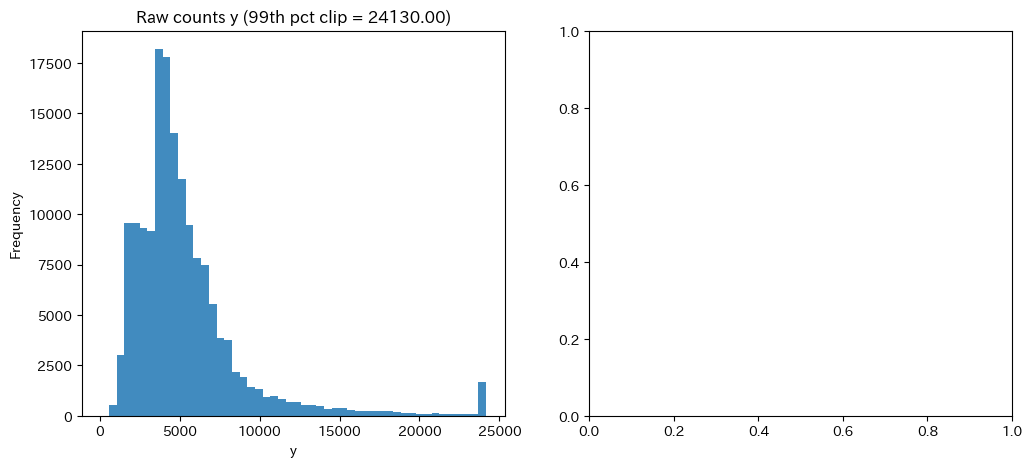

In [18]:
run_full_did_analysis(final_df)